In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import seaborn as sns   
import scipy.optimize as sco


In [78]:
#ticker list = XLB, XLE, XLF, XLI, XLK, XLP, XLU, XLV, XLY
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
#download etf data start= 2011-01-01 and actions =False to remove dividends
etf_hist = etf.history(start='2015-01-01', end = '2021-01-01', actions=False)
#keep Close column
etf_close = etf_hist['Close']
etf_close.tail()

[*********************100%%**********************]  9 of 9 completed


,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,
2020-12-24,67.295563,33.691654,27.345427,83.870201,125.748032,61.792694,55.780853,106.385071,154.235489
2020-12-28,67.032310,33.479530,27.477667,83.975044,127.170586,62.283558,56.026905,106.652290,155.993912
2020-12-29,66.872482,33.258568,27.383211,83.469917,126.566483,62.098324,56.017792,107.158119,156.042740
2020-12-30,67.793854,33.780029,27.506004,84.003639,126.498291,62.033497,56.300297,107.139046,156.980621
2020-12-31,68.057076,33.497204,27.846050,84.394394,126.683403,62.468765,57.138699,108.265213,157.068497


In [79]:
#return calculation
etf_return = etf_close.pct_change().fillna(0)
ret_vec = etf_return.mean() * 252
cov_mat = etf_return.cov()  * 252

In [80]:
#defining efficinet frontier resampling function
def resampled_efficient_frontier(rv, covmat , size =252, N_path = 50, N_point = 50, resampling =True):
    #number of assets
    n_assets = len(rv)
    if resampling: 
        #simulation for resampling
        ret_vec_stack = np.zeros((N_path, len(rv)))
        covmat_stack = np.zeros((N_path, len(rv), len(rv)))
        
        #create path for resampling
        for i in range(N_path):
            #random number from multivariate normal distribution
            randn = np.random.multivariate_normal(rv, covmat, size)
            #new return vector
            ret_vec_i  = randn.mean(axis=0)
            ret_vec_stack[i,:] = ret_vec_i
            #new covariance matrix
            covmat_i = np.cov(randn.T)
            covmat_stack[i,:,:] = covmat_i
        
        #newly updated return vector and covariance matrix    
        new_ret_vec = ret_vec_stack.mean(axis=0)
        new_covmat = covmat_stack.mean(axis=0)
    else:
        new_ret_vec = rv
        new_covmat = covmat
        
    #objective funciton for optimization    
    def obj_function(weights):
        weights = np.array(weights)
        #investment vol
        pvol = np.sqrt(np.dot(weights.T, np.dot(new_covmat, weights)))
        return pvol
    
    #perform portfolio optimization for each level of return
    trets = np.linspace(0.1, 0.2, N_path)
    tvols = []
    weights = np.random.random(n_assets)
    weights /= np.sum(weights)
    
        
    for tret in trets:
        #initialie weight vector = equal weight
        init_guess = np.repeat(1/n_assets, n_assets)
        #constraints for optimization
        cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
                {'type': 'eq', 'fun': lambda x: np.sum(x * new_ret_vec) - tret})
        #bounds for optimization for each assets (no short selling)
        #bnds based on weights 
        bnds = tuple((0,1) for x in weights)
        #optimization
        res = sco.minimize(obj_function, init_guess, method='SLSQP', bounds=bnds, constraints=cons)
        #append portfolio vol that meets the target retun that fits the voliatlity
        tvols.append(res['fun'])
    #convert vol likst to array
    tvols = np.array(tvols)
    #return efficient frontier
    return tvols, trets


In [81]:
#resampling efficient frontier 0 = no resampling, 1 = resampling
new_trets, new_tvols = resampled_efficient_frontier(ret_vec, cov_mat, resampling=True)
#efficient frontier without resampling
trets, tvols = resampled_efficient_frontier(ret_vec, cov_mat, resampling=False)

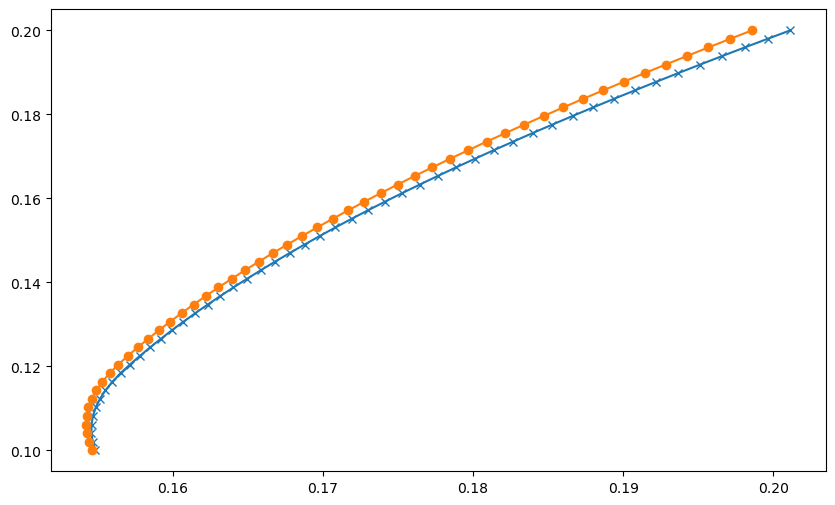

In [88]:
#resmpaling efficient frontier plot
plt.figure(figsize=(10,6))
plt.plot(trets, tvols, marker='x', label='Original')
plt.plot(new_trets, new_tvols, marker='o', label='Resampled')

#파란색이 원래 efficient frontier, 주황색이 resampling efficient frontier
#resmapling 하는 이유: 원래 과거 데이터에 대한 확신이 없을때 , 
#샘플링기법을 통해서 확인해보는 것 